In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle 
import numpy as np
import pandas as pd
import torch
import os
from timeit import default_timer as timer
import networkx as nx
import scipy.sparse as sp

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [42]:
from core.SimpleNet import SimpleNet
from core.OldGraphConvNet import OldGraphConvNet
from core.EmbeddingDataSet import EmbeddingDataSet
from util.plot_graph_embedding import plot_graph_embedding
from util.evaluation_metrics import get_net_projection, graph_trustworthiness, trustworthiness
from util.graph_utils import get_shortest_path_matrix

In [4]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [5]:
if torch.cuda.is_available():
    print('cuda available')
    device = 'cuda'
else:
    print('cuda not available')
    device = 'cpu'

cuda not available


In [6]:
dataset_name = 'cora'
parent_dir = os.path.abspath('..')
input_dir = os.path.join(parent_dir, 'data')
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(n_batches=1, shuffle=False)
dataset.summarise()

Name of dataset = cora
Input dimension = 1433
Number of training samples = 2485
Training labels = True
Graph information = True


In [7]:
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = dataset.input_dim # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 10 # number of hidden layers

In [8]:
# Graph net
net_1 = OldGraphConvNet(net_parameters)
if torch.cuda.is_available(): net_1.cuda()
root = 'results/cora_9/'
filename = root + 'graph_net_1000.pkl'
checkpoint = torch.load(filename, map_location=device)
net_1.load_state_dict(checkpoint['state_dict'])

In [9]:
# Simple net
net_2 = SimpleNet(net_parameters)
if torch.cuda.is_available(): net_2.cuda()
root = 'results/cora_10/'
filename = root + 'simple_net_3000.pkl'
checkpoint = torch.load(filename, map_location=device)
net_2.load_state_dict(checkpoint['state_dict'])

In [10]:
# Graph net
net_3 = OldGraphConvNet(net_parameters)
if torch.cuda.is_available(): net_3.cuda()
root = 'results/cora_11/'
filename = root + 'graph_net_1000.pkl'
checkpoint = torch.load(filename, map_location=device)
net_3.load_state_dict(checkpoint['state_dict'])

In [11]:
# Simple net
net_4 = SimpleNet(net_parameters)
if torch.cuda.is_available(): net_4.cuda()
root = 'results/cora_12/'
filename = root + 'simple_net_3000.pkl'
checkpoint = torch.load(filename, map_location=device)
net_4.load_state_dict(checkpoint['state_dict'])

In [12]:
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(n_batches=1, shuffle=False)

In [44]:
# tSNE
D = pairwise_distances(dataset.inputs, metric='cosine')
beta = 0
affinity_matrix = beta * dataset.adj_matrix * D
D = D - affinity_matrix

embedder = TSNE(n_components=2, metric='precomputed', method="exact", perplexity=30, verbose=1)
y_pred_tsne = embedder.fit_transform(D)

[t-SNE] Computed conditional probabilities for sample 1000 / 2485
[t-SNE] Computed conditional probabilities for sample 2000 / 2485
[t-SNE] Computed conditional probabilities for sample 2485 / 2485
[t-SNE] Mean sigma: 0.171635
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.785306
[t-SNE] KL divergence after 1000 iterations: 1.913701


In [14]:
# Spectral
from sklearn.manifold import SpectralEmbedding
affinity_matrix = 1 - D 
embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
y_pred_spectral = embedding.fit_transform(affinity_matrix)

In [15]:
y_pred_1 = get_net_projection(dataset.all_data, net_1)

In [16]:
y_pred_2 = get_net_projection(dataset.all_data, net_2)

In [17]:
y_pred_3 = get_net_projection(dataset.all_data, net_3)

In [18]:
y_pred_4 = get_net_projection(dataset.all_data, net_4)

In [45]:
plot_graph_embedding(y_pred_tsne, dataset.labels, dataset.adj_matrix)

In [20]:
plot_graph_embedding(y_pred_spectral, dataset.labels, dataset.adj_matrix)

In [21]:
plot_graph_embedding(y_pred_1, dataset.labels, dataset.adj_matrix)

In [22]:
plot_graph_embedding(y_pred_2, dataset.labels, dataset.adj_matrix)

In [23]:
plot_graph_embedding(y_pred_3, dataset.labels, dataset.adj_matrix)

In [24]:
plot_graph_embedding(y_pred_4, dataset.labels, dataset.adj_matrix)

In [26]:
import scipy.sparse as sp

path_matrix = get_shortest_path_matrix(sp.coo_matrix(dataset.adj_matrix))
path_matrix.shape

Computing all pairs shortest path lengths...
Time to compute shortest paths (s) = 23.6774


(2485, 2485)

In [27]:
embedder = TSNE(n_components=2, metric='precomputed', method="exact", perplexity=30, verbose=1)
y_pred_tsne_2 = embedder.fit_transform(path_matrix)

[t-SNE] Computed conditional probabilities for sample 1000 / 2485
[t-SNE] Computed conditional probabilities for sample 2000 / 2485
[t-SNE] Computed conditional probabilities for sample 2485 / 2485
[t-SNE] Mean sigma: 0.579707
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.988494
[t-SNE] KL divergence after 1000 iterations: 1.218550


In [28]:
plot_graph_embedding(y_pred_tsne_2, dataset.labels, dataset.adj_matrix)

In [29]:
# # Graph net
# net_parameters['L'] = 10
# net_4 = OldGraphConvNet(net_parameters)
# if torch.cuda.is_available(): net_4.cuda()
# root = 'results/cora_8/'
# filename = root + 'graph_net_1000.pkl'
# checkpoint = torch.load(filename, map_location=device)
# net_4.load_state_dict(checkpoint['state_dict'])
# net_4.eval()

In [30]:
# dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
# dataset.create_all_data(n_batches=2, shuffle=False)
# y_pred_4 = get_net_projection(dataset.all_data, net_4)
# y_pred_4 = y_pred_4[np.argsort(dataset.all_indices)]
# plot_graph_embedding(y_pred_4, labels, adj)

In [46]:
embeddings_dict = {'tsne': y_pred_tsne,
                   'tsne (path lengths)': y_pred_tsne_2,
                   'graph_10L (path lengths)': y_pred_1, 
                   'simple (path lengths)': y_pred_2,
                   'graph_10L (mixed)': y_pred_3,
                   'simple (mixed)': y_pred_4}

In [47]:
def graph_trustworthiness(path_matrix, X_emb, n_neighbors=5):
    dist_X_emb = pairwise_distances(X_emb, squared=True)
    ind_X_emb = np.argsort(dist_X_emb, axis=1)[:, 1:n_neighbors + 1]

    n_samples = X_emb.shape[0]
    t = 0.0
    min_sum = 0.0
    max_sum = 0.0
    for i in range(n_samples):
        ranks = path_matrix[i][ind_X_emb[i, :]]
        t += np.sum(ranks)
        lengths_from_i = sorted(path_matrix[i])
        min_sum += sum(lengths_from_i[1:n_neighbors + 1])
        max_sum += sum(lengths_from_i[-n_neighbors:])
    t = 1.0 - (t - min_sum) / (max_sum - min_sum)
    return t

Text(0.5,1,'Graph trustworthiness')

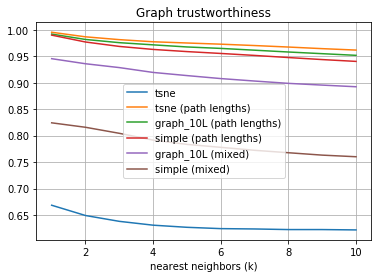

In [48]:
test_range = list(range(1, 11))
scores = np.zeros(len(test_range))

for label, embedding in embeddings_dict.items():
    for i, k in enumerate(test_range):
        scores[i] = graph_trustworthiness(path_matrix, embedding, n_neighbors=k)
    plt.plot(test_range, scores, label=label)
        
plt.legend()
plt.xlabel('nearest neighbors (k)')
plt.grid(True)
plt.title('Graph trustworthiness')

In [49]:
def neighborhood_preservation(path_matrix, X_emb, max_graph_dist=2):
    dist_X_emb = pairwise_distances(X_emb, squared=True)
    ind_X_emb = np.argsort(dist_X_emb, axis=1)[:, 1:]

    n_samples = X_emb.shape[0]
    t = 0.0
    for i in range(n_samples):
        graph_n = {k for k, v in enumerate(path_matrix[i]) if 0 < v <= max_graph_dist}
        layout_n= set(ind_X_emb[i][:len(graph_n)])
        intersection_size = len(graph_n.intersection(layout_n))
        t += intersection_size / (2*len(graph_n) - intersection_size)
    return t/n_samples

Text(0.5,1,'Graph preservation')

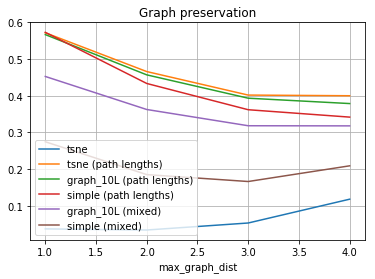

In [50]:
test_range = list(range(1, 5))
scores = np.zeros(len(test_range))

for label, embedding in embeddings_dict.items():
    for i, k in enumerate(test_range):
        scores[i] = neighborhood_preservation(path_matrix, embedding, max_graph_dist=k)
    plt.plot(test_range, scores, label=label)
        
plt.legend()
plt.xlabel('max_graph_dist')
plt.grid(True)
plt.title('Graph preservation')

Text(0.5,1,'Similarity preservation')

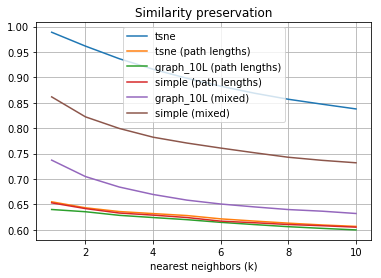

In [51]:
test_range = list(range(1, 11))
scores = np.zeros(len(test_range))

D = pairwise_distances(dataset.inputs, metric='cosine')

for label, embedding in embeddings_dict.items():
    for i, k in enumerate(test_range):
        scores[i] = trustworthiness(D, embedding, precomputed=True, n_neighbors=k)
    plt.plot(test_range, scores, label=label)
        
plt.legend()
plt.xlabel('nearest neighbors (k)')
plt.grid(True)
plt.title('Similarity preservation')